In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.offline as pyoff

from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, InputLayer, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("D:\Projects\Sales_EDA_Dashboard\Data\Processed\Sales_Data_Clean.csv")
df.head()

,Unnamed: 0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour,Year,Day,Weekday
0,0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0,2019,30,Monday
1,1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7,2019,29,Sunday
2,2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18,2019,12,Thursday
3,3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15,2019,22,Sunday
4,4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12,2019,18,Wednesday


In [16]:
# Chuyển cột Order Date sang kiểu datetime
#Chuyển đổi "Order Date" thành kiểu dữ liệu Datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        185950 non-null  int64         
 1   Order ID          185950 non-null  int64         
 2   Product           185950 non-null  object        
 3   Quantity Ordered  185950 non-null  int64         
 4   Price Each        185950 non-null  float64       
 5   Order Date        185950 non-null  datetime64[ns]
 6   Purchase Address  185950 non-null  object        
 7   Month             185950 non-null  int64         
 8   Sales             185950 non-null  float64       
 9   City              185950 non-null  object        
 10  Hour              185950 non-null  int64         
 11  Year              185950 non-null  int64         
 12  Day               185950 non-null  int64         
 13  Weekday           185950 non-null  object        
dtypes: d

In [17]:
df["Date"] = df["Order Date"].dt.date

# Nhóm dữ liệu theo ngày, tổng hợp doanh thu theo ngày
df = df.groupby("Date")["Sales"].sum().reset_index()

In [18]:
df.head(5)

,Date,Sales
0,2019-01-01,65681.94
1,2019-01-02,70813.20
2,2019-01-03,47046.20
3,2019-01-04,62012.21
4,2019-01-05,46524.63


In [19]:
Q1 = df["Sales"].quantile(0.25)
Q3 = df["Sales"].quantile(0.75)

# Tính IQR
IQR = Q3 - Q1

# Xác định các giá trị ngoại lai
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc các giá trị ngoại lai
outliers_iqr = df[(df['Sales'] < lower_bound) | (df["Sales"] > upper_bound)]

print("Các giá trị ngoại lai theo IQR:")
print(outliers_iqr)

Các giá trị ngoại lai theo IQR:
           Date      Sales
337  2019-12-04  166727.69
343  2019-12-10  162832.74
349  2019-12-16  162970.61
365  2020-01-01    8670.29


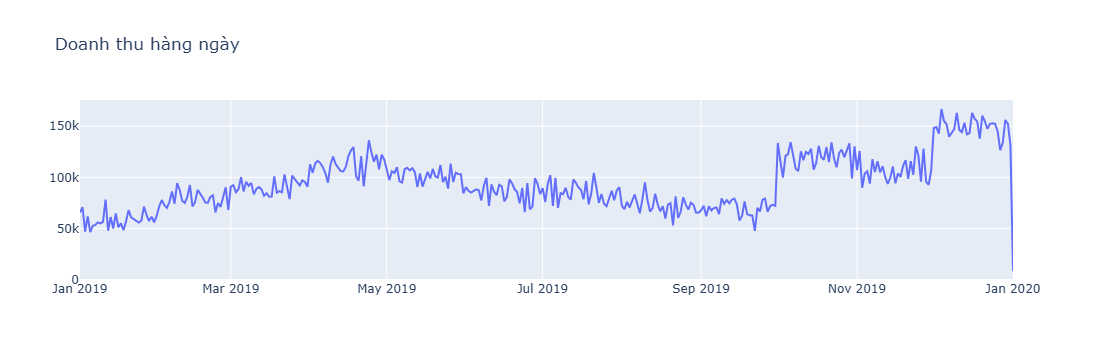

In [20]:
# Biểu đồ doanh thu theo ngày
plot_data = [
    go.Scatter(
        x = df["Date"],
        y = df["Sales"],
    )
]

plot_layout = go.Layout(
    title = "Doanh thu hàng ngày"
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

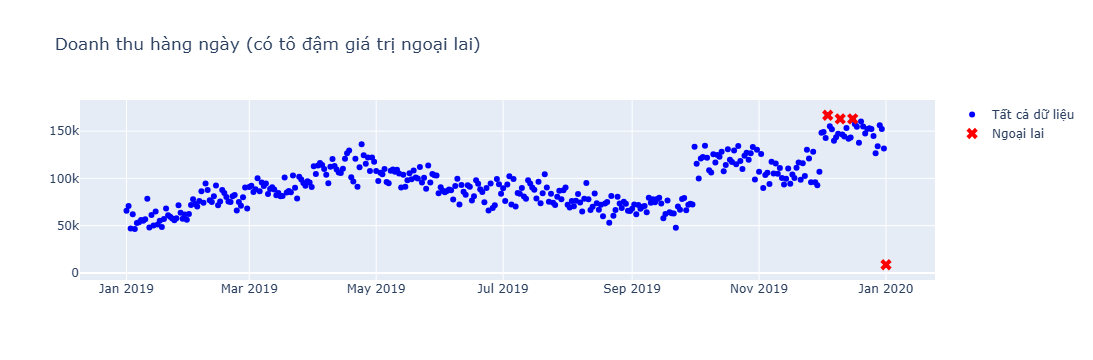

In [21]:
# Vẽ toàn bộ dữ liệu
trace_all = go.Scatter(
    x = df["Date"],
    y = df["Sales"],
    mode='markers',
    name='Tất cả dữ liệu',
    marker=dict(color='blue')
)

# Vẽ riêng điểm ngoại lai
outliers = df[(df["Sales"] < lower_bound) | (df["Sales"] > upper_bound)]
trace_outliers = go.Scatter(
    x = outliers["Date"],
    y = outliers["Sales"],
    mode='markers',
    name='Ngoại lai',
    marker=dict(color='red', size=10, symbol='x')
)

layout = go.Layout(
    title = "Doanh thu hàng ngày (có tô đậm giá trị ngoại lai)"
)

fig = go.Figure(data=[trace_all, trace_outliers], layout=layout)
pyoff.iplot(fig)


In [22]:
# Xóa outliers
df_clean = df[(df["Sales"] >= lower_bound) & (df["Sales"] <= upper_bound)].copy()

print("\nKích thước dữ liệu ban đầu:", df.shape)
print("Kích thước dữ liệu sau khi xóa outlier:", df_clean.shape)


Kích thước dữ liệu ban đầu: (366, 2)
Kích thước dữ liệu sau khi xóa outlier: (362, 2)


In [23]:
# Đảm bảo cột Date đúng kiểu
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.sort_values("Date").reset_index(drop=True)

# Tạo lag features
df_supervised = df_clean.copy()
for i in range(1, 8):
    df_supervised[f"lag_{i}"] = df_supervised["Sales"].shift(i)

# Loại bỏ NaN
df_supervised = df_supervised.dropna().reset_index(drop=True)

# Tách X và y
X = df_supervised[[f"lag_{i}" for i in range(1, 8)]]
y = df_supervised["Sales"]

In [24]:
df_supervised.shape

(355, 9)

In [25]:
# Chia train-test data
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
print("Tổng số dòng:", len(X))
print("Số dòng X_train:", len(X_train))
print("Số dòng X_test:", len(X_test))
print("Tổng train + test:", len(X_train) + len(X_test))  # nên bằng len(X)

print("Số dòng y_train:", len(y_train))
print("Số dòng y_test:", len(y_test))

Tổng số dòng: 355
Số dòng X_train: 284
Số dòng X_test: 71
Tổng train + test: 355
Số dòng y_train: 284
Số dòng y_test: 71


In [27]:
#### Chuẩn hóa dữ liệu (Scale data)
# Khởi tạo scaler cho đặc trưng X và mục tiêu y
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Fit scaler_X chỉ trên X_train, rồi transform cả X_train và X_test
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Fit scaler_y chỉ trên y_train, rồi transform cả y_train và y_test
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [28]:
# Reshape X
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Reshape y (nếu cần)
y_train_reshaped = y_train_scaled.reshape(-1, 1)
y_test_reshaped = y_test_scaled.reshape(-1, 1)

In [29]:
# Khởi tạo mô hình
model = Sequential()

# Thêm lớp LSTM vào mô hình
model.add(LSTM(100, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

# Thêm lớp Dense
model.add(Dense(1))

# Biên dịch mô hình
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train_reshaped, y_train_scaled, epochs=100, batch_size=16, verbose=1, shuffle=False)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1310
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0606
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0633
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0575
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0558
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0542
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0544
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0538
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0539
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0536
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0536
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0536
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0532
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0535
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0531
Epoc

In [18]:
# Dự đoán trên tập test
y_pred_scaled = model.predict(X_test_reshaped)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [19]:
scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_y.fit(y_train.values.reshape(-1, 1))

# scale y
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Sau dự đoán:
y_pred_scaled = model.predict(X_test_reshaped)

# inverse lại
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [27]:
mae = mean_absolute_error(y_test_true, y_pred)
rmse = sqrt(mean_squared_error(y_test_true, y_pred))
mape = np.mean(
    np.abs((y_test_true - y_pred) / np.where(y_test_true == 0, np.nan, y_test_true))
) * 100
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")

MAE : 13,802.10
RMSE: 16,641.36
MAPE: 10.65%


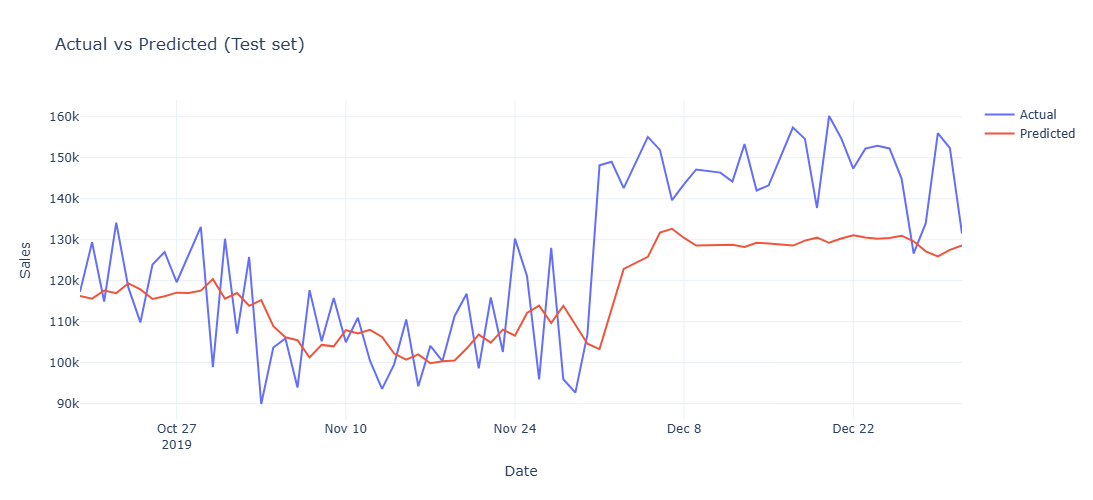

In [28]:
# Lấy ngày tương ứng với X_test từ df_supervised
dates_test = pd.to_datetime(df_supervised['Date'].iloc[train_size:].values)

trace_actual = go.Scatter(x=dates_test, y=y_test_true.flatten(), mode='lines', name='Actual')
trace_pred   = go.Scatter(x=dates_test, y=y_pred.flatten(), mode='lines', name='Predicted')

fig = go.Figure(data=[trace_actual, trace_pred])
fig.update_layout(title='Actual vs Predicted (Test set)', xaxis_title='Date', yaxis_title='Sales',
                  width=1100, height=500, template='plotly_white')
pyoff.iplot(fig)

Residual mean: 8501.25


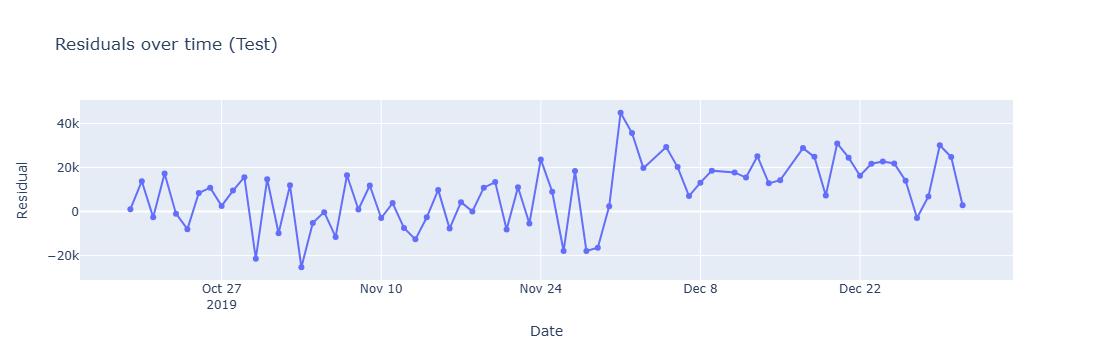

In [29]:
# residuals (actual - pred)
residuals = (y_test_true.flatten() - y_pred.flatten())
print("Residual mean:", residuals.mean().round(2))

# 2a) Residual time series (Plotly)
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_test, y=residuals, mode='lines+markers', name='Residuals'))
fig.update_layout(title='Residuals over time (Test)', xaxis_title='Date', yaxis_title='Residual')
pyoff.iplot(fig)


In [30]:
# --- Tạo X_full, y_full từ df_supervised (đã dropna) ---
X_full = df_supervised[[f"lag_{i}" for i in range(1,8)]].values
y_full = df_supervised["Sales"].values.reshape(-1,1)

# Fit scalers on FULL data (để dùng khi forecast)
scaler_X_full = MinMaxScaler(feature_range=(-1,1))
scaler_y_full = MinMaxScaler(feature_range=(-1,1))

X_full_scaled = scaler_X_full.fit_transform(X_full)
y_full_scaled = scaler_y_full.fit_transform(y_full)

# reshape cho LSTM: (samples, timesteps, features) -> timesteps = 7, features = 1
X_full_reshaped = X_full_scaled.reshape((X_full_scaled.shape[0], X_full_scaled.shape[1], 1))

# Build and train model_full (you can reuse architecture)
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_full = Sequential()
model_full.add(LSTM(100, input_shape=(X_full_reshaped.shape[1], X_full_reshaped.shape[2])))
model_full.add(Dense(1))
model_full.compile(loss='mean_squared_error', optimizer='adam')

# train (you can adjust epochs/batch_size)
model_full.fit(X_full_reshaped, y_full_scaled, epochs=100, batch_size=16, verbose=1, shuffle=False)


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1344
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0422
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0394
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0383
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0381
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0384
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0387
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0383
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0393
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0389
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403
Epoc

In [17]:
# Lấy last known lags: đây là hàng cuối cùng của X_full (chưa scaled)
last_lags = X_full[-1, :]  # shape (7,)

# scale last_lags using scaler_X_full (scaler expects 2D)
last_lags_scaled = scaler_X_full.transform(last_lags.reshape(1, -1))  # shape (1,7)

# reshape to (1, timesteps, features)
last_input = last_lags_scaled.reshape((1, last_lags_scaled.shape[1], 1))

future_steps = 30
future_preds_scaled = []

for _ in range(future_steps):
    pred_scaled = model_full.predict(last_input, verbose=0)  # returns scaled y (shape (1,1))
    future_preds_scaled.append(pred_scaled[0,0])
    # shift last_input: drop first timestep, append new predicted sales as newest lag
    # last_input currently shape (1, 7, 1) -> we want to make new array (1,7,1)
    last_input = np.append(last_input[:,1:,:], pred_scaled.reshape(1,1,1), axis=1)

# inverse transform preds
future_preds = scaler_y_full.inverse_transform(np.array(future_preds_scaled).reshape(-1,1)).flatten()

# tạo index ngày (dự báo theo ngày)
last_date = pd.to_datetime(df_clean['Date'].iloc[-1])  # df_clean có cột Date và đã sorted
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds})
future_df.head()


NameError: name 'X_full' is not defined

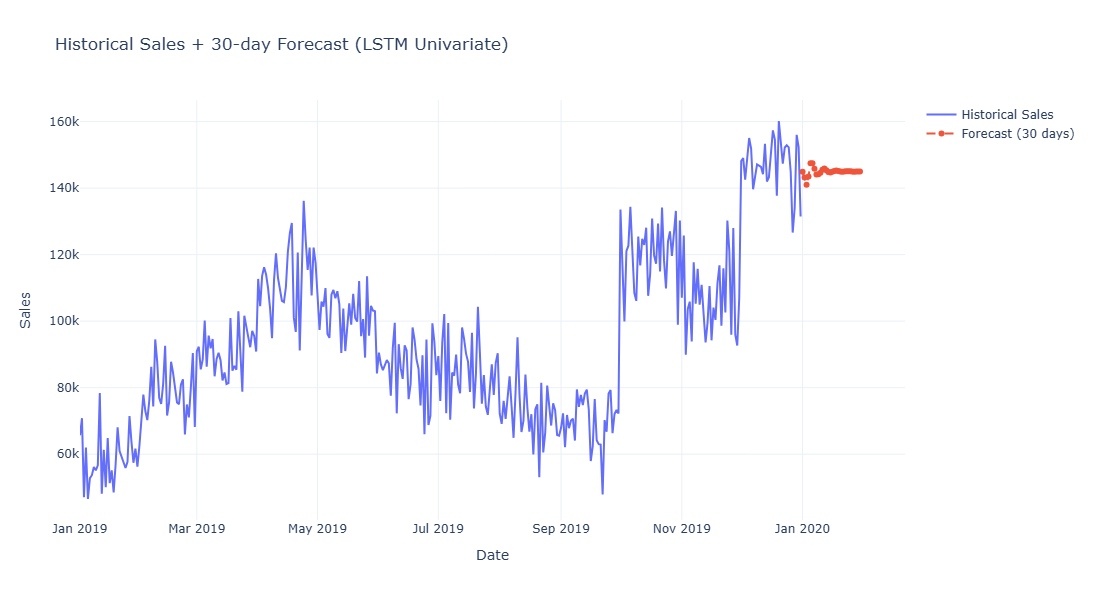

In [32]:
# Lịch sử đầy đủ (df_clean) - đảm bảo Date dạng datetime
hist_dates = pd.to_datetime(df_clean['Date'])
hist_sales  = df_clean['Sales'].values

trace_hist = go.Scatter(x=hist_dates, y=hist_sales, mode='lines', name='Historical Sales')
trace_fore = go.Scatter(x=future_df['Date'], y=future_df['Forecast'], mode='lines+markers', name='Forecast (30 days)',
                        line=dict(dash='dash'), marker=dict(size=6))

fig = go.Figure(data=[trace_hist, trace_fore])
fig.update_layout(title='Historical Sales + 30-day Forecast (LSTM Univariate)',
                  xaxis_title='Date', yaxis_title='Sales', width=1200, height=600, template='plotly_white')
pyoff.iplot(fig)
